# Loan Default Prediction
Nama : William

Batch : RMT-020

Dataset : Dataset yang digunakan berisikan data finansial dan status kehidupan dari customer yang menunggak dan tidak menunggak pinjaman dari bank. data ini merupakan milik Hackathon yang diselenggarakan oleh "Univ.AI" 

[Link Dataset](https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior?select=Training+Data.csv)

Objective : Sebuah perusahaan peminjaman uang ingin memprediksi siapa yang mungkin menajadi defaulters untuk pinjaman uang. perusahaan tersebut memiliki data historikal mengenai perilaku customer . Jadi ketika ada pelanggan baru yang mengajukan peminjaman uang,perusahaaan ingin mengetahui apakah pelanggan tersebut beresiko atau tidak. disini perusahaan meminta membuat model prediksi dengan setidaknya standar akurasinya ialah 85%

[Link Model Deployment](https://huggingface.co/spaces/William14045/loan_risk_flag_prediction)

[Link Dashboard EDA](https://lookerstudio.google.com/reporting/1b710b7a-8876-414e-96dd-284a8db69bc7)

# Import Libraries

In [3]:
# Import Library yang akan digunakan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import tensorflow as tf


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder , StandardScaler , OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression                                       
from sklearn.tree import DecisionTreeClassifier
from joblib import dump
import pickle
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report , confusion_matrix

# Data Loading

In [4]:
# Load Data
df = pd.read_csv("Loan_Data.csv")
df.head(5) # Melihat 5 data dengan urutan Teratas


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [5]:
df.tail(5) # Melihat 5 data dengan urutan terbawah

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
251995,251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251996,251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251997,251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0
251998,251999,6507128,45,0,single,rented,no,Graphic_Designer,Pondicherry,Puducherry,0,10,0
251999,252000,9070230,70,17,single,rented,no,Statistician,Avadi,Tamil_Nadu,7,11,0


In [6]:
df.duplicated().value_counts()

False    252000
Name: count, dtype: int64

# Exploratory Data Analysis ( EDA )

sebelum melakukan manipulasi pada Data saya ingin melakukan eksplorasi pada data aslinya terlebih dahulu

In [7]:
# membuat rentang income per 1 juta  untuk keperluan Plotting
df['income_range'] = pd.cut(df['Income'], bins=range(0, 10000001, 1000000), right=False)

Text(0.5, 1.0, 'Income')

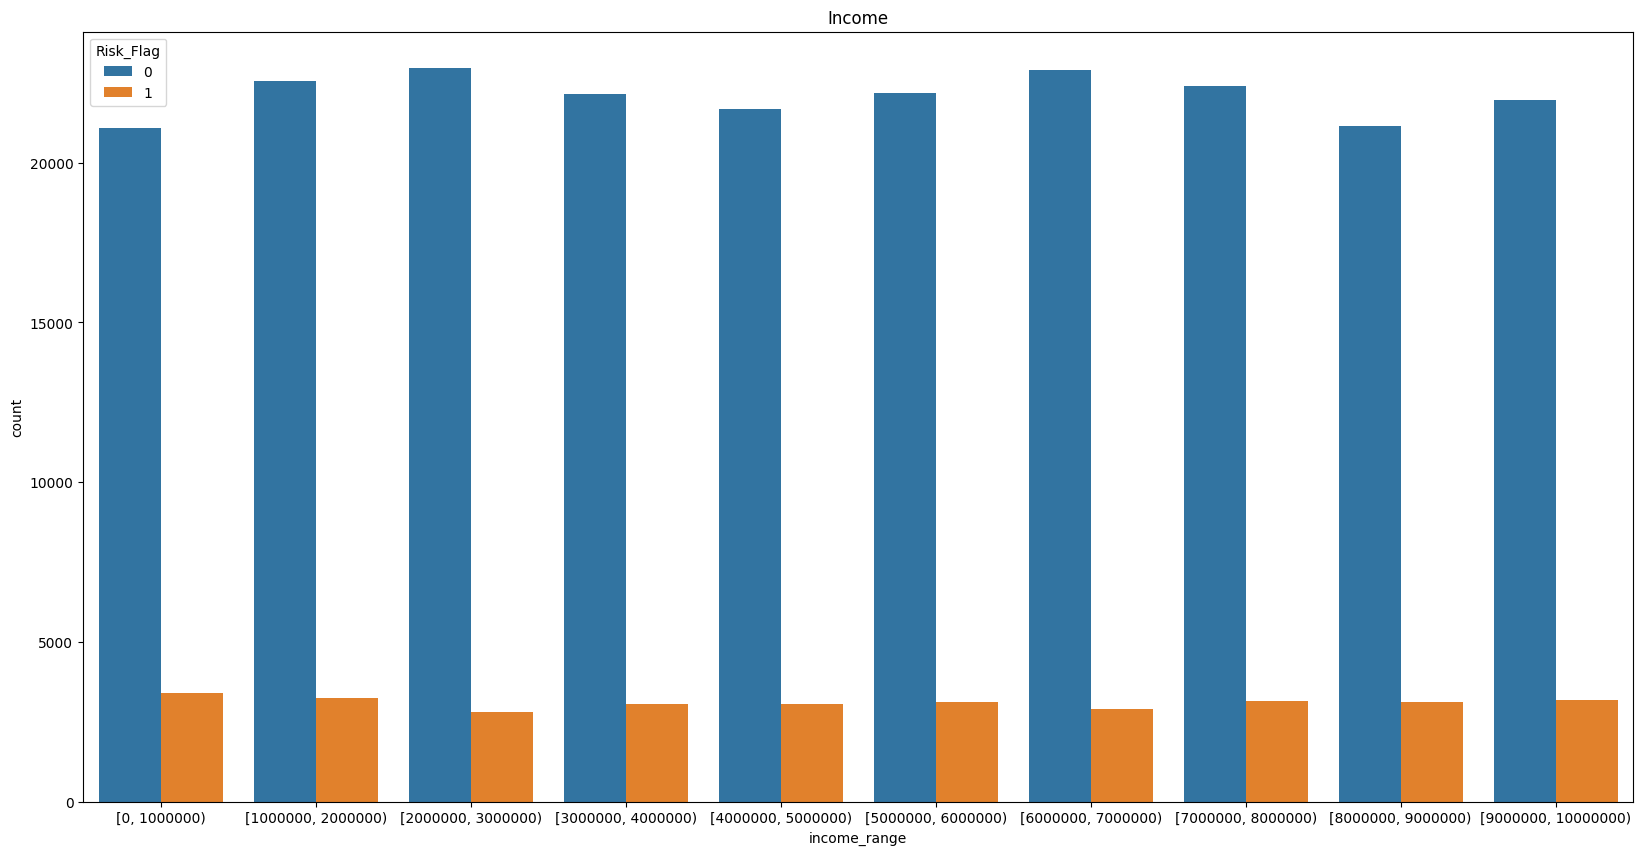

In [8]:
plt.figure(figsize=(20,10))
sns.countplot(data=df,x='income_range',hue='Risk_Flag')
plt.title('Income')

In [9]:
# Rata-rata kemungkinan seseorang Default berdasarkan income nya
df.groupby("income_range").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
income_range,
"[0, 1000000)",13.837661
"[8000000, 9000000)",12.809202
"[9000000, 10000000)",12.614369
"[1000000, 2000000)",12.535878
"[4000000, 5000000)",12.384376
"[7000000, 8000000)",12.355771
"[5000000, 6000000)",12.317666
"[3000000, 4000000)",12.123016
"[6000000, 7000000)",11.231772


In [10]:
df = df.drop('income_range',axis=1) # Menghapus kolom yang tidak digunakan lagi

Pada distribusi gaji dalam data ini, terlihat bahwa jumlah individu dalam setiap kategori gaji hampir merata. Tidak terdapat perbedaan signifikan dalam jumlah individu antar kategori gaji. sedangkan dengan kemungkinan seseorang akan menunggak berada pada rentang gaji terkecil yaitu 0-1 juta. hal ini bisa saja dikarenakan pendapatan seseorang yang kecil tidak mampu menutup jumlah pinjaman nya

In [11]:
# membuat rentang per 5 tahun untuk keperluan Plotting
df['age_range'] = pd.cut(df['Age'], bins=range(20, 81, 5), right=False)

Text(0.5, 1.0, 'Age')

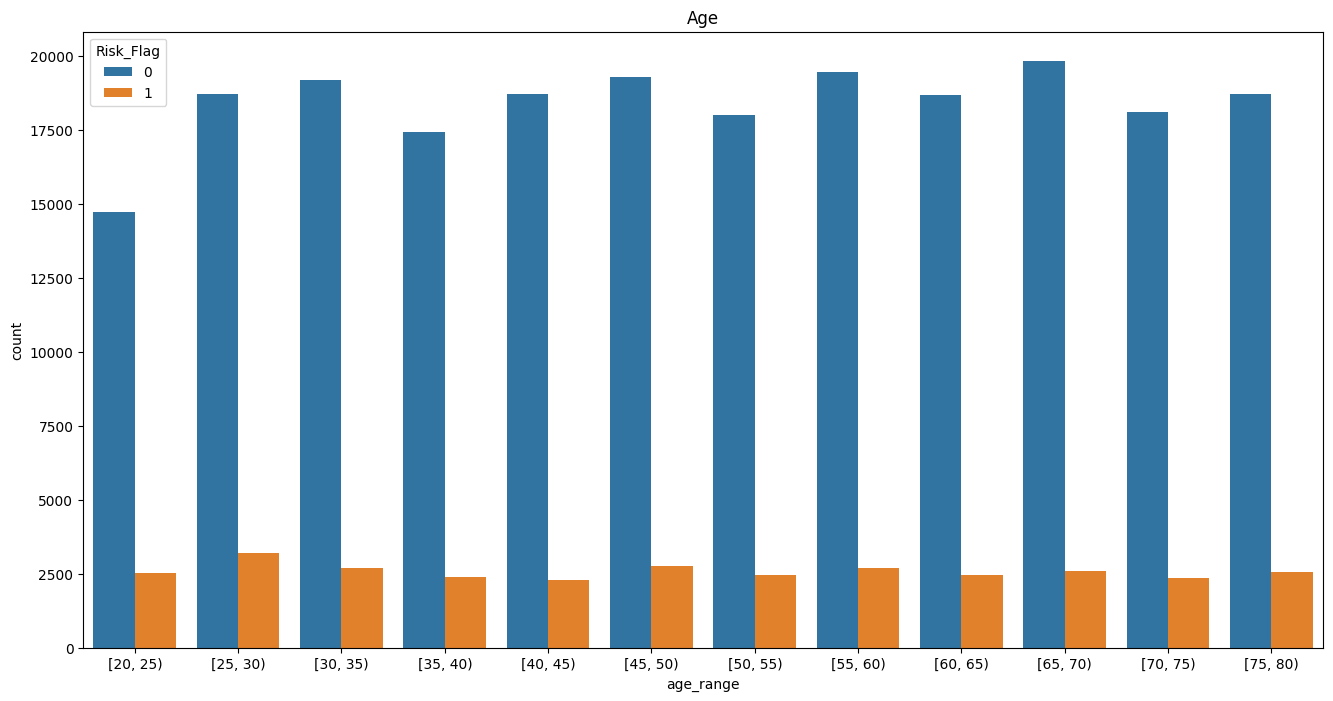

In [12]:
plt.figure(figsize=(16,8))
sns.countplot(data=df,x='age_range',hue='Risk_Flag')
plt.title('Age')


In [13]:
# Rata-rata kemungkinan seseorang Default berdasarkan Umurnya
df.groupby("age_range").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
age_range,
"[20, 25)",14.667592
"[25, 30)",14.580480
"[45, 50)",12.537354
"[30, 35)",12.291039
"[35, 40)",12.101044
"[55, 60)",12.099066
"[75, 80)",12.085486
"[50, 55)",12.033377
"[65, 70)",11.601693


In [14]:
df = df.drop('age_range',axis=1) # Menghapus kolom yang tidak digunakan lagi

berdasarkan umurnya, pada data ini customer dengan umur 20-25 tahun jumlah nya lebih sedikit dibandingkan yang lain tetapi memiliki kemungkinan menunggak palng besar

Text(0.5, 1.0, 'Work Experience in Year')

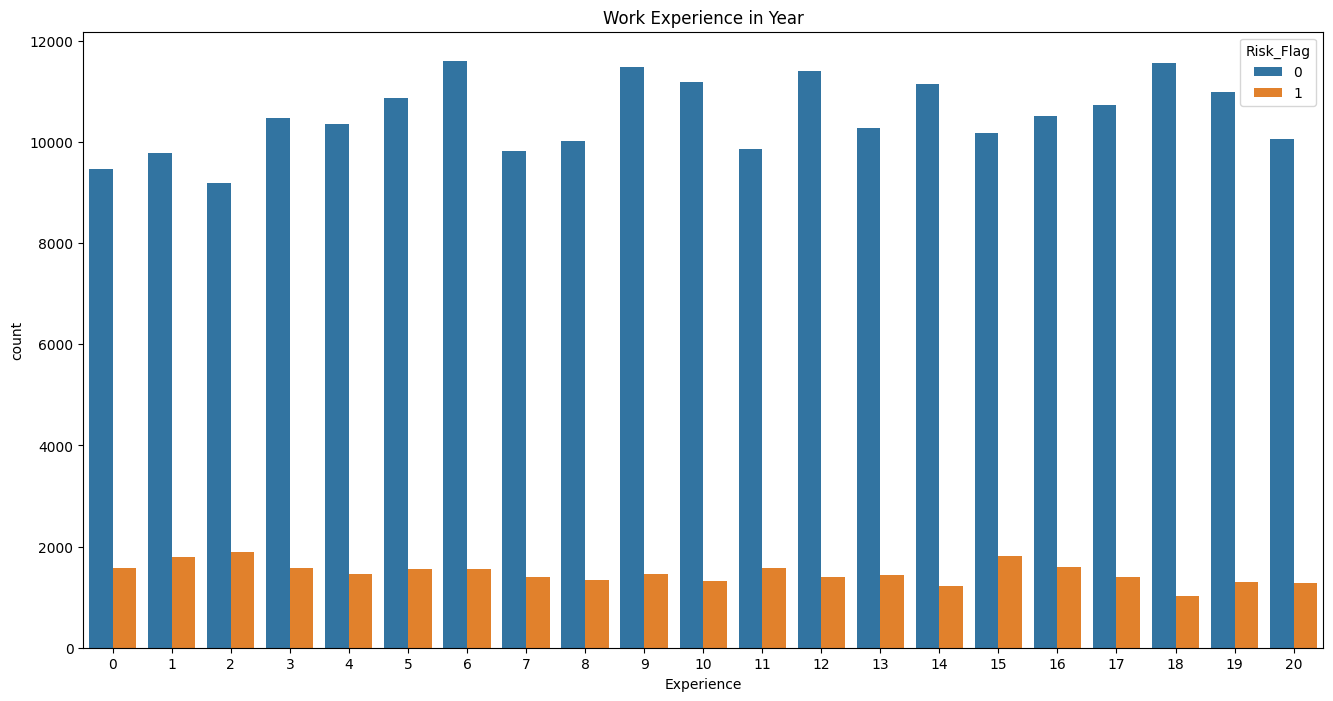

In [15]:
plt.figure(figsize=(16,8))
sns.countplot(data=df,x='Experience',hue='Risk_Flag')
plt.title('Work Experience in Year')

In [16]:
# Rata-rata kemungkinan seseorang Default berdasarkan Umurnya
df.groupby("Experience").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
Experience,
2,17.046992
1,15.568035
15,15.075461
0,14.325817
11,13.835269
16,13.216587
3,13.141105
5,12.579375
7,12.491097


In [17]:
df['Income'].corr(df['Experience']) # Mengecek korelasi linear antara income dan experience

0.006421644992922629

berdasarkan pengalaman kerjanya, orang dengan pengalaman bekerja yang sedikit cenderung lebih riskan menunggak. Hal ini bisa saja terjadi dikarenakan pengalaman bekerja yang sedikit berimpact juga terhadap income seseorang tidak terlalu besar. meskipun pada data ini income dan experience tidak memiliki nilai korelasi yang besar, tetapi berdasarkan [Link ini](https://medium.com/@dharmayudafebrianto/mengetahui-hubungan-pengalaman-kerja-terhadap-gaji-karyawan-di-suatu-perusahaan-2ffff33333a2), kedua variable tersebut berpengaruh satu sama lain

Text(0.5, 1.0, 'Marital Status')

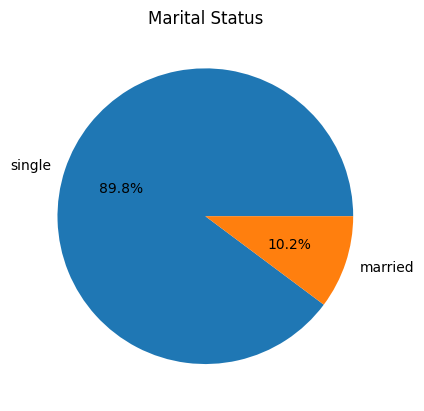

In [18]:
plt.pie(df['Married/Single'].value_counts(),labels=df['Married/Single'].value_counts().index,autopct='%1.1f%%')
plt.title('Marital Status')

Text(0.5, 1.0, 'Marital Status')

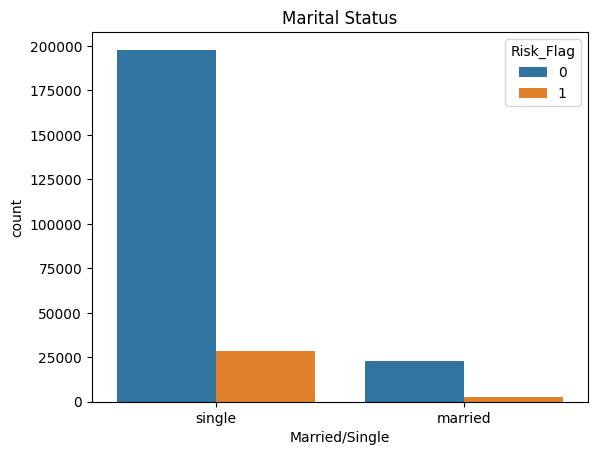

In [19]:
sns.countplot(data=df,x='Married/Single',hue='Risk_Flag')
plt.title('Marital Status')

In [20]:
# Rata-rata kemungkinan seseorang Default berdasarkan status pernikahan nya
df.groupby("Married/Single").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
Married/Single,
single,12.533588
married,10.245647


pada data ini, sebagian besar customer belum menikah, akan tetapi berdasarkan risk flag nya, customer yang single kemungkinan menunggak nya lebih besar dibandingkan seseorang yang telah menikah. hal ini dapat diasumsikan bahwa dalam konteks ini, individu yang belum menikah mungkin memiliki lebih sedikit tanggung jawab keuangan secara keseluruhan dibandingkan dengan mereka yang sudah menikah. Ini bisa berarti bahwa mereka cenderung mengelola keuangan mereka dengan kurang hati-hati atau mungkin lebih cenderung untuk mengabaikan kewajiban pembayaran. Atau bisa juga Individu yang sudah menikah mungkin memiliki pasangan yang dapat memberikan dukungan finansial dalam situasi darurat atau saat sulit. Orang yang belum menikah mungkin tidak memiliki dukungan finansial yang sama, sehingga mereka lebih rentan terhadap kesulitan keuangan.

Text(0.5, 1.0, 'House Ownership')

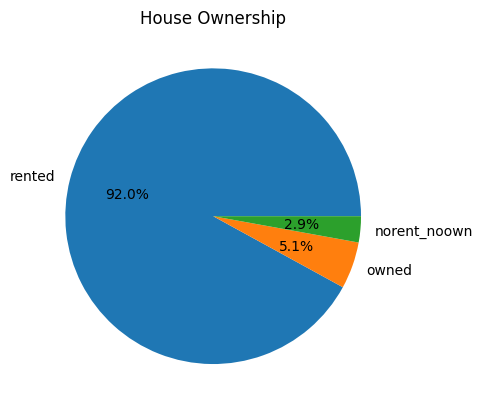

In [21]:
plt.pie(df['House_Ownership'].value_counts(),labels=df['House_Ownership'].value_counts().index,autopct='%1.1f%%')
plt.title('House Ownership')

Text(0.5, 1.0, 'House Ownership')

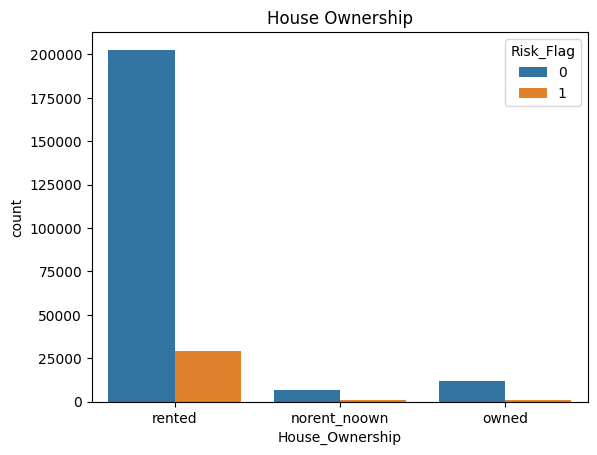

In [22]:
sns.countplot(data=df,x='House_Ownership',hue='Risk_Flag')
plt.title('House Ownership')

In [23]:
# Rata-rata kemungkinan seseorang Default berdasarkan Tempat Tinggalnya
df.groupby("House_Ownership").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
House_Ownership,
rented,12.557676
norent_noown,9.952673
owned,8.979718


terlihat bahwa orang yang menyewa rumah memiliki kecenderungan yang lebih tinggi untuk mengalami keterlambatan pembayaran atau menunggak, dibandingkan dengan individu yang memiliki rumah atas nama sendiri atau bahkan mereka yang tidak memiliki rumah sama sekali. hal ini bisa terjadi karena Di beberapa daerah, harga sewa dapat sangat tinggi dibandingkan dengan biaya kepemilikan rumah. Ini bisa membuat pembayaran sewa menjadi beban yang lebih berat pada anggaran bulanan individu yang menyewa. atau juga Orang yang menyewa mungkin memiliki kendali yang lebih terbatas atas biaya sewa yang bisa naik dari waktu ke waktu. Ini dapat menghadirkan tantangan tambahan dalam mengelola anggaran.

Text(0.5, 1.0, 'Car Ownership')

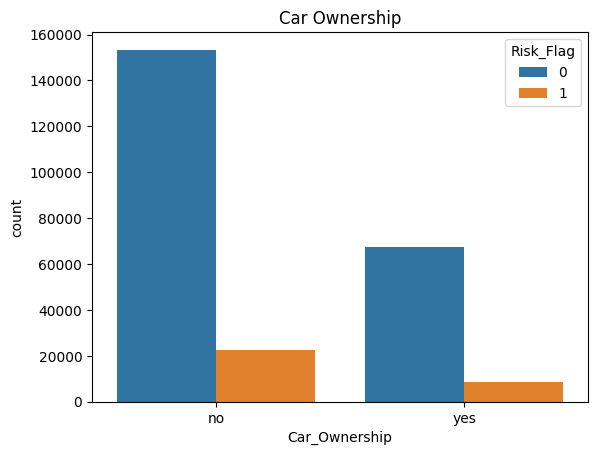

In [24]:
sns.countplot(data=df,x='Car_Ownership',hue='Risk_Flag')
plt.title('Car Ownership')

In [25]:
# Rata-rata kemungkinan seseorang Default berdasarkan Kepemilikan Mobil
df.groupby("Car_Ownership").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
Car_Ownership,
no,12.818750
yes,11.098684


individu yang tidak memiliki mobil memiliki risiko yang lebih tinggi untuk mengalami penunggakan dibandingkan dengan mereka yang memiliki mobil. hal ini bisa terjadi karena Tidak memiliki mobil dapat mengindikasikan keterbatasan dalam mobilitas ekonomi. Ini mungkin mengarah pada pendapatan yang lebih rendah atau pekerjaan yang kurang stabil, yang pada gilirannya dapat mempengaruhi kemampuan seseorang untuk membayar tagihan secara tepat waktu. atau juga Jika seseorang tidak memiliki mobil, mereka mungkin harus mengandalkan transportasi umum atau layanan berbayar untuk bergerak. Biaya transportasi yang lebih tinggi ini dapat mempengaruhi anggaran mereka dan membuat lebih sulit untuk mengelola kewajiban keuangan lainnya.

Text(0.5, 1.0, '10 Profesi Terbanyak Di data')

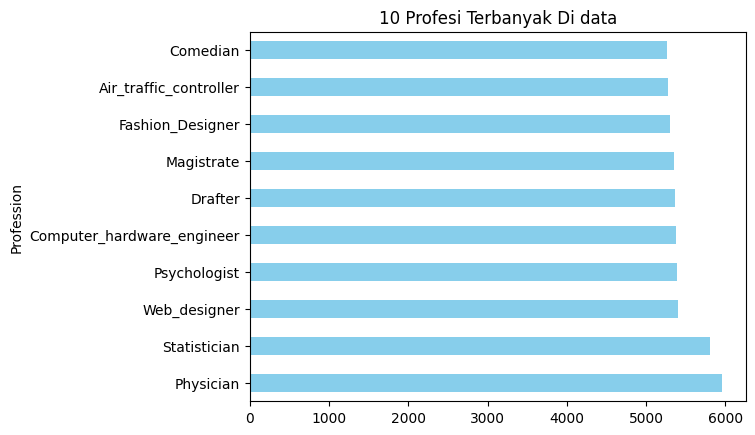

In [26]:
df['Profession'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title('10 Profesi Terbanyak Di data')

In [27]:
# Rata-rata kemungkinan seseorang Default berdasarkan Pekerjaan nya
df.groupby("Profession").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame().head(10)

,Risk_Flag
Profession,
Police_officer,16.405164
Chartered_Accountant,15.357222
Army_officer,15.211328
Surveyor,15.146373
Software_Developer,14.842668
Scientist,14.432127
Geologist,14.426370
Civil_engineer,13.583189
Official,13.579643


 Profesi seperti "Police_officer," "Chartered_Accountant," dan "Army_officer" memiliki nilai "Risk_Flag" yang relatif tinggi. Profesi yang rentan terhadap perubahan ekonomi atau fluktuasi industri tertentu mungkin memiliki risiko default yang lebih tinggi. Misalnya, jika industri tertentu sedang mengalami penurunan, pekerja dalam industri ini mungkin lebih mungkin mengalami kesulitan dalam membayar tagihan. atau bisa juga Profesi tertentu mungkin memiliki norma-norma perilaku keuangan yang lebih buruk, seperti kecenderungan untuk mengambil risiko atau pengeluaran yang tidak terkontrol. Ini dapat berkontribusi pada risiko default yang lebih tinggi.

Text(0.5, 1.0, '10 Kota Terbanyak Di data')

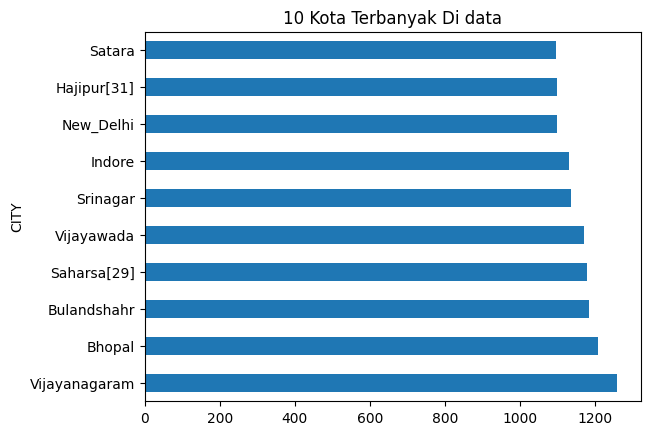

In [28]:
df['CITY'].value_counts().head(10).plot(kind='barh')
plt.title('10 Kota Terbanyak Di data')

In [29]:
# Rata-rata kemungkinan seseorang Default berdasarkan Kota Tempat Tinggal nya
df.groupby("CITY").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame().head(10)

,Risk_Flag
CITY,
Bhubaneswar,32.619440
Gwalior,27.272727
Bettiah[33],26.695842
Kochi,25.286160
Raiganj,23.955432
Purnia[26],23.886640
Barasat,23.870220
Sikar,23.845194
Buxar[37],23.147208


 Kota seperti "Bhubaneswar," "Gwalior," dan "Bettiah" memiliki nilai "Risk_Flag" yang relatif tinggi. Variasi ini bisa disebabkan oleh faktor-faktor ekonomi, demografi, atau perilaku keuangan yang unik dalam masing-masing kota. Faktor-faktor ini bisa termasuk tingkat pengangguran, pendapatan rata-rata, tingkat pendidikan, stabilitas ekonomi, dan lain-lain

Text(0.5, 1.0, '10 Negara Bagian Terbanyak Di data')

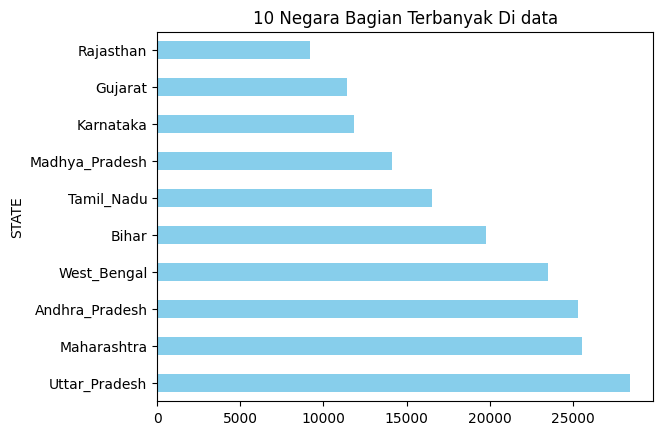

In [30]:
df['STATE'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title('10 Negara Bagian Terbanyak Di data')

In [31]:
# Rata-rata kemungkinan seseorang Default berdasarkan STATE Tempat Tinggal nya
df.groupby("STATE").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame().head(10)

,Risk_Flag
STATE,
Manipur,21.554770
Tripura,16.810878
Kerala,16.709733
Jammu_and_Kashmir,15.898876
Madhya_Pradesh,15.436907
Odisha,14.255045
Rajasthan,14.083279
Jharkhand,13.329615
Chhattisgarh,13.328117


Negara bagian seperti "Manipur," "Tripura," dan "Kerala" memiliki nilai "Risk_Flag" yang relatif tinggi. Negara bagian dengan pertumbuhan ekonomi yang lambat atau industri yang kurang berkembang mungkin mengalami tingkat pengangguran yang lebih tinggi dan pendapatan rata-rata yang lebih rendah. Ini bisa berkontribusi pada risiko gagal bayar yang lebih tinggi karena kesulitan individu dalam membayar tagihan atau utang.

Text(0.5, 1.0, 'Lamanya Bekerja di Pekerjaan sekarang ( Tahun )')

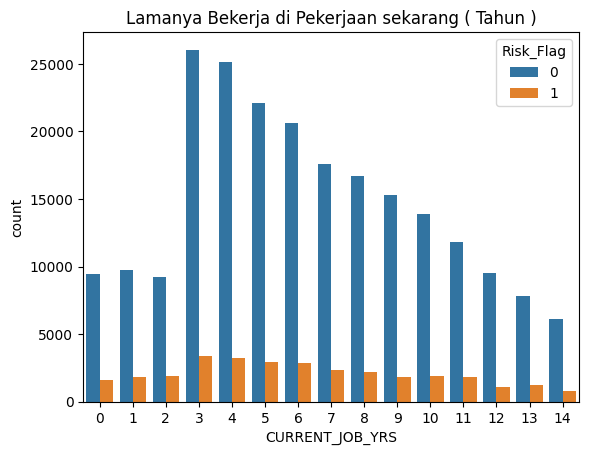

In [32]:
sns.countplot(data=df,x='CURRENT_JOB_YRS',hue='Risk_Flag')
plt.title('Lamanya Bekerja di Pekerjaan sekarang ( Tahun )')

In [33]:
# Rata-rata kemungkinan seseorang Default berdasarkan STATE Tempat Tinggal nya
df.groupby("CURRENT_JOB_YRS").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
CURRENT_JOB_YRS,
2,17.046992
1,15.568035
0,14.325817
13,13.968568
11,13.254873
6,12.217445
10,11.922882
5,11.844885
14,11.813187


Individu dengan lama kerja saat ini yang lebih pendek, seperti 0 tahun, 1 tahun, dan 2 tahun, memiliki nilai "Risk_Flag" yang lebih tinggi. Nilai "Risk_Flag" tampaknya menurun secara bertahap seiring dengan bertambahnya lama kerja hingga mencapai puncak pada sekitar 2 tahun. Ini mungkin menunjukkan bahwa individu yang telah bekerja lebih lama dalam pekerjaan saat ini memiliki stabilitas kerja yang lebih baik dan, akibatnya, risiko penunggakan yang lebih rendah.

Text(0.5, 1.0, 'Lamanya Tinggal di Rumah Sekarang')

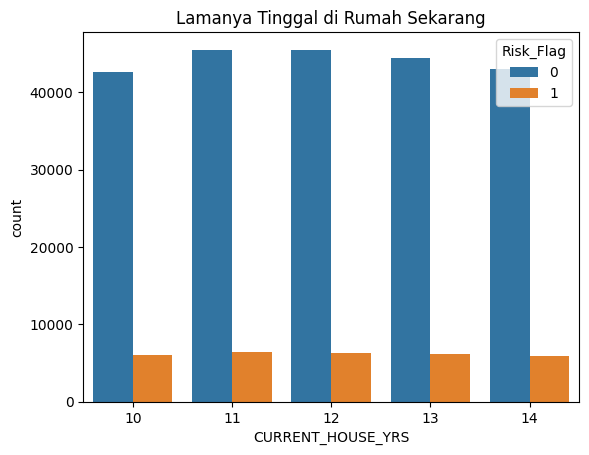

In [34]:
sns.countplot(data=df,x='CURRENT_HOUSE_YRS',hue='Risk_Flag')
plt.title('Lamanya Tinggal di Rumah Sekarang')

In [35]:
# Rata-rata kemungkinan seseorang Default berdasarkan STATE Tempat Tinggal nya
df.groupby("CURRENT_HOUSE_YRS").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame()

,Risk_Flag
CURRENT_HOUSE_YRS,
11,12.497831
10,12.495377
13,12.203162
12,12.171999
14,12.131910


untuk lamanya seseorang tinggal di suatu tempat tidak terlalu berpengaruh terhadap kemungkinan seseorang menunggak dikarenakan jumlah "risk_flag" yang relatif mirip satu sama lain

Text(0.5, 1.0, 'Risk Flag')

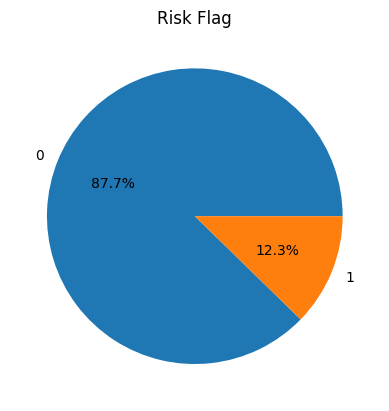

In [36]:
plt.pie(df['Risk_Flag'].value_counts(),labels=df['Risk_Flag'].value_counts().index,autopct='%1.1f%%')
plt.title('Risk Flag')

Risk Flag disini ialah variabel  / kolom yang akan dijadikan target pemodelan nantinya. dapat dilihat bahwa data yang dimiliki bersifat imbalanced dengan nilai 0 yang jauh lebih banyak dibandingkan 1

# Feature Engineering

selanjutnya sebelum masuk ke pemodelan saya akan melakukan manipulasi pada data agar saat dimasukkan ke dalam pemodelan hasilnya diharapkan dapat lebih baik. disini saya menghapus kolom ID terlebih dahulu dikarenakan tidak ada nya informasi yang bisa di dapat dari kolom ID

In [37]:
df.drop('Id',axis=1,inplace=True)

## Handling Cardinality

In [38]:
df['CITY'].nunique()

317

untuk menghandle cardinality pada kolom CITY, saya membuat cluster baru yang berisikian Tier dari kota yang ada di India dengan referensi : https://en.wikipedia.org/wiki/Classification_of_Indian_cities

In [39]:
# Fungsi untuk mengganti nama kota menjadi tier
def map_to_tier(city):
    if city in ['Ahmedabad', 'Bengaluru', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune']:
        return 'Tier 1'
    elif city in ['Agra', 'Ajmer', 'Aligarh', 'Amravati', 'Amritsar', 'Anand', 'Asansol', 'Aurangabad', 'Bareilly', 'Belagavi',
          'Brahmapur', 'Bhavnagar', 'Bhiwandi', 'Bhopal', 'Bhubaneswar', 'Bikaner', 'Bilaspur','Bokaro',
          'Burdwan' , 'Chandigarh', 'Coimbatore', 'Cuttack', 'Dahod', 'Dehradun', 'Dombivli', 'Dhanbad', 'Bhilai',
          'Durgapur', 'Erode', 'Faridabad', 'Ghaziabad', 'Gorakhpur', 'Guntur', 'Gurgaon', 'Guwahati', 'Gwalior', 'Hamirpur',
          'Hubballi-Dharwad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jalgaon', 'Jammu','Jamshedpur', 'Jhansi', 'Jodhpur',
          'Kalaburagi', 'Kakinada', 'Kannur', 'Kanpur', 'Karnal', 'Kochi', 'Kolhapur', 'Kollam', 'Kozhikode', 'Kurnool', 'Ludhiana',
          'Lucknow', 'Madurai', 'Malappuram', 'Mathura', 'Mangaluru', 'Meerut', 'Moradabad', 'Mysuru', 'Nagpur', 'Nanded', 'Nadiad',
          'Nashik', 'Nellore', 'Noida', 'Patna', 'Puducherry', 'Purulia', 'Prayagraj', 'Raipur', 'Rajkot', 'Rajamahendravaram',
          'Ranchi', 'Rourkela', 'Ratlam', 'Salem', 'Sangli', 'Shimla', 'Siliguri', 'Solapur', 'Srinagar', 'Surat', 'Thanjavur',
          'Thiruvananthapuram', 'Thrissur', 'Tiruchirappalli', 'Tirunelveli', 'Tiruvannamalai', 'Ujjain', 'Vijayapura',
          'Vadodara', 'Varanasi', 'Vasai-Virar', 'Vijayawada', 'Visakhapatnam', 'Vellore','Warangal']:
        return 'Tier 2'
    else:
        return 'Tier 3'

In [40]:
df['CITY'] = df['CITY'].apply(lambda x: map_to_tier(x))

In [41]:
df['CITY'].value_counts()

CITY
Tier 3    185496
Tier 2     61932
Tier 1      4572
Name: count, dtype: int64

In [42]:
df['STATE'].nunique()

29

sedangkan untuk state disini saya  mengelompokkannya menjadi 4 value saja berdasarkan letak geografis nya pada negara India

In [43]:
# Fungsi untuk menggolongkan negara bagian berdasarkan wilayah
def classify_region(state):
    if state in ['Haryana', 'Himachal_Pradesh', 'Jharkhand', 'Punjab', 'Uttar_Pradesh','Uttar_Pradesh[5]', 'Uttarakhand','Jammu_and_Kashmir','Delhi','Chandigarh']:
        return 'North'
    elif state in ['Andhra_Pradesh', 'Karnataka', 'Kerala', 'Tamil_Nadu', 'Telangana']:
        return 'South'
    elif state in ['Goa', 'Gujarat', 'Maharashtra', 'Rajasthan','Madhya_Pradesh']:
        return 'West'
    elif state in ['Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Sikkim', 'Tripura', 'West_Bengal','Puducherry']:
        return 'East'
    else:
        return 'Unknown'

In [44]:
df['STATE'] =df['STATE'].apply(lambda x: classify_region(x))

In [45]:
df['STATE'].value_counts()

STATE
South    67018
East     63365
North    61351
West     60266
Name: count, dtype: int64

## Splitting Train & Test Data

In [46]:
df['Risk_Flag'].value_counts()

Risk_Flag
0    221004
1     30996
Name: count, dtype: int64

dikarenakan target yang imbalanced. saya ingin mencoba mencari mana kah yang lebih baik, data yang tidak diubah, data yang di undersampling, atau data yang di oversampling

In [47]:
X = df.drop(['Risk_Flag'],axis=1)
y = df['Risk_Flag']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

print('Train Size : ', X_train.shape)
print('Test Size : ', X_test.shape)

Train Size :  (201600, 11)
Test Size :  (50400, 11)


In [49]:
# Under sampling
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersampler.fit_resample(X_train, y_train)


dikarenakan untuk melakukan oversampling semua data harus berupa numerikal, saya melakukan preprocessing terhadap data terlebih dahulu

In [50]:
cat = X_train.select_dtypes(include=['object']).columns.tolist() # Memisahkan kolom categorical
cat

['Married/Single',
 'House_Ownership',
 'Car_Ownership',
 'Profession',
 'CITY',
 'STATE']

In [51]:
ordinal_cat = ['CITY']
cat.remove('CITY')
cat.remove('Profession')
cat

['Married/Single', 'House_Ownership', 'Car_Ownership', 'STATE']

In [52]:
num = X_train.select_dtypes(include=np.number).columns.tolist() # Memisahkan kolom numerical
num

['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

In [53]:
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[['Tier 3', 'Tier 2', 'Tier 1']])),  
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

over_pipe = ColumnTransformer(transformers=[
    ('ord', ordinal_transformer, ordinal_cat),
    ('nom', nominal_transformer, cat),
    ('num', numerical_transformer, num)
])


In [54]:
train_over = over_pipe.fit_transform(X_train)
train_over

array([[ 0.        ,  0.        ,  1.        , ...,  1.31968625,
         0.73272555, -0.71420249],
       [ 0.        ,  0.        ,  1.        , ...,  0.98651875,
        -0.36442399, -0.71420249],
       [ 1.        ,  0.        ,  1.        , ..., -0.01298378,
        -0.0901366 ,  1.42866008],
       ...,
       [ 0.        ,  0.        ,  1.        , ..., -1.01248631,
        -0.63871137, -1.42849001],
       [ 1.        ,  0.        ,  1.        , ..., -1.34565382,
        -1.18728614, -0.71420249],
       [ 0.        ,  1.        ,  0.        , ..., -0.17956754,
         0.73272555, -0.71420249]])

In [55]:
# Over sampling
smote = SMOTE(random_state=9)
X_smote, y_smote = smote.fit_resample(train_over, y_train)

## Missing Value

In [56]:
X_train.isnull().sum()

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64

Data yang akan digunakan tidak mengandung missing value

## Outliers

In [57]:
pd.options.display.float_format = '{:.2f}'.format
X_train.describe() # Melihat Preview data Numerikal

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
count,201600.00,201600.00,201600.00,201600.00,201600.00
mean,4997617.57,49.96,10.08,6.33,12.00
std,2877862.89,17.07,6.00,3.65,1.40
min,10310.00,21.00,0.00,0.00,10.00
25%,2504515.00,35.00,5.00,3.00,11.00
50%,5002101.00,50.00,10.00,6.00,12.00
75%,7476486.50,65.00,15.00,9.00,13.00
max,9999400.00,79.00,20.00,14.00,14.00


jika dilihat sekilas dari preview nya, sepertinya data tidak memiliki outlier, dilihat dari standar deviasi yang lebih kecil daripada mean. standar deviasi yang lebih besar daripada mean bisa menjadi salah satu petunjuk bahwa data mungkin mengandung outlier. Namun, perlu diperhatikan bahwa ini hanya merupakan petunjuk awal, dan tidak selalu berlaku dalam semua kasus. Standar deviasi yang lebih besar daripada mean menunjukkan variasi yang lebih besar antara nilai-nilai dalam dataset. Jika ada outlier yang jauh dari nilai-nilai lainnya, hal ini dapat menyebabkan standar deviasi yang lebih besar. Tetapi juga mungkin ada variasi yang besar di antara nilai-nilai tanpa adanya outlier.

In [58]:
Q1 = X_train['Income'].quantile(0.25)
Q3 = X_train['Income'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = X_train[(X_train['Income'] < lower_bound) | (X_train['Income'] > upper_bound)]
outliers.shape


(0, 11)

In [59]:
Q1 = X_train['Experience'].quantile(0.25)
Q3 = X_train['Experience'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = X_train[(X_train['Experience'] < lower_bound) | (X_train['Experience'] > upper_bound)]
outliers.shape

(0, 11)

pada 2 code diatas saya mencoba melihat keberadaan outlier pada kolom Income dan Experience. dan pada 2 kolom tersebut tidak ada outlier . shape dari 2 code diatas ialah (0,11) yang artinya 0 baris dan 11 kolom

Text(0.5, 1.0, 'Boxplot Age')

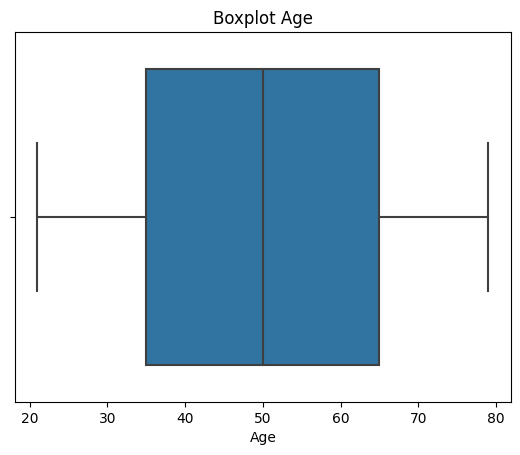

In [60]:
sns.boxplot(x=X_train['Age'])
plt.title('Boxplot Age')

Text(0.5, 1.0, 'Boxplot Current Job Years')

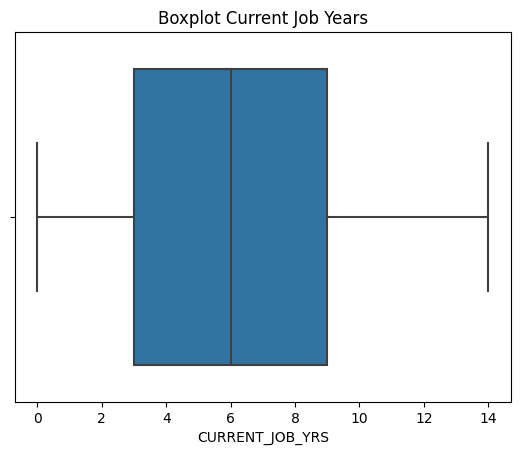

In [61]:
sns.boxplot(x=X_train['CURRENT_JOB_YRS'])
plt.title('Boxplot Current Job Years')

Text(0.5, 1.0, 'Boxplot Current House Years')

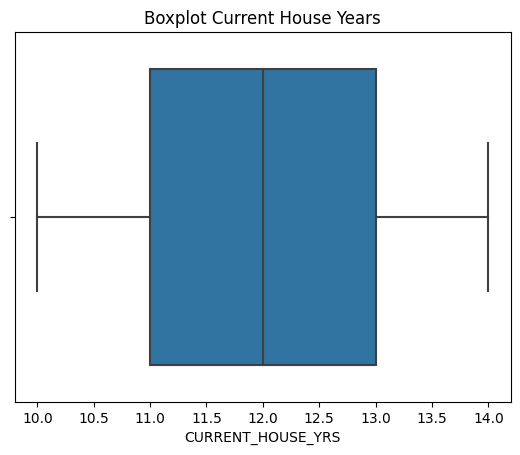

In [62]:
sns.boxplot(x=X_train['CURRENT_HOUSE_YRS'])
plt.title('Boxplot Current House Years')

dari hasil pengecekan menggunakan metode IQR dan BoxPlot, tidak ditemukan Outlier pada Data

## Checking Correlation

Selanjutnya saya ingin mengecek korelasi antar fitur terhadap Target

In [63]:
num = X_train.select_dtypes(include=np.number).columns.tolist() # Memisahkan kolom numerical
num

['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

In [64]:
for i in num:
    correlation, p_value = stats.pointbiserialr(y_train, X_train[i]) # melakukan pengecekan korelasi antar fitur numerical terhadap target
    print('koefisien korelasi biserial antara kolom',i,'dan Risk Flag :',correlation)

koefisien korelasi biserial antara kolom Income dan Risk Flag : -0.0033361052816901905
koefisien korelasi biserial antara kolom Age dan Risk Flag : -0.022791772115040854
koefisien korelasi biserial antara kolom Experience dan Risk Flag : -0.035342534265357044
koefisien korelasi biserial antara kolom CURRENT_JOB_YRS dan Risk Flag : -0.017605306099223943
koefisien korelasi biserial antara kolom CURRENT_HOUSE_YRS dan Risk Flag : -0.0035283540439091142


In [65]:
cat = X_train.select_dtypes(include=['object']).columns.tolist() # Memisahkan kolom categorical
cat

['Married/Single',
 'House_Ownership',
 'Car_Ownership',
 'Profession',
 'CITY',
 'STATE']

In [66]:
for i in cat:
    contingency_table = pd.crosstab(X_train[i],y_train)

    # Menghitung koefisien korelasi Cramér's V
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table) # melakukan pengecekan korelasi antar fitur categorical terhadap target
    n = contingency_table.sum().sum()
    phi_c = np.sqrt(chi2 / (n * min(contingency_table.shape)-1))    
    # Menampilkan hasil
    print("Koefisien Korelasi",i,'dengan Risk Flag : ', phi_c)

Koefisien Korelasi Married/Single dengan Risk Flag :  0.014777823868616398
Koefisien Korelasi House_Ownership dengan Risk Flag :  0.018306975293802857
Koefisien Korelasi Car_Ownership dengan Risk Flag :  0.015108592022350917


Koefisien Korelasi Profession dengan Risk Flag :  0.03634584330068293
Koefisien Korelasi CITY dengan Risk Flag :  0.007798693762674734
Koefisien Korelasi STATE dengan Risk Flag :  0.014163232968995071


Dikarenakan Tidak Adanya fitur yang memiliki korelasi setidaknya diatas 0.1( 10% ) dengan Target, saya akan menggunakan semua fiturnya

## Preprocessing Pipeline

Untuk Tahap Preprocessing disini saya membaginya menjadi 3 step yaitu yang pertama melakukan ordinal Encoding pada data yang bersifat ordinal. contohnya pada data ini ialah kolom city. selanjutnya saya menggunakan OneHotEncoder terhadap kolom categorical yang lain yang bersifat non ordinal. untuk kolom numerikal disini saya menggunakan StandardScaler dikarenakan distribusi data pada kolom-kolom numerikal bersifat normal ( Gaussian )

In [67]:
ordinal_cat = ['CITY']
cat.remove('CITY')
cat.remove('Profession')
cat

['Married/Single', 'House_Ownership', 'Car_Ownership', 'STATE']

In [68]:
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[['Tier 3', 'Tier 2', 'Tier 1']])),  
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('ord', ordinal_transformer, ordinal_cat),
    ('nom', nominal_transformer, cat),
    ('num', numerical_transformer, num)
])


In [69]:
final_X_train = preprocessor.fit_transform(X_train)          # melakukan transformasi pada data melalui proses pipeline yang telah dibuat
final_X_test = preprocessor.transform(X_test)
train_under = preprocessor.transform(X_under)


# Model Definition

## Logistic Regression

### Original

In [70]:
logreg = LogisticRegression()
logreg.fit(final_X_train,y_train)

LogisticRegression()

In [71]:
print('Training score: {:.4f}'.format(logreg.score(final_X_train, y_train)))
print('Test score: {:.4f}'.format(logreg.score(final_X_test, y_test)))

Training score: 0.8762
Test score: 0.8804


### Undersampling

In [72]:
under_log = LogisticRegression()
under_log.fit(train_under,y_under)

LogisticRegression()

In [73]:
print('Training score: {:.4f}'.format(under_log.score(train_under, y_under)))
print('Test score: {:.4f}'.format(under_log.score(final_X_test, y_test)))

Training score: 0.5385
Test score: 0.5198


### Oversampling

In [74]:
over_log = LogisticRegression()
over_log.fit(X_smote,y_smote)

LogisticRegression()

In [75]:
print('Training score: {:.4f}'.format(over_log.score(X_smote,y_smote)))
print('Test score: {:.4f}'.format(over_log.score(final_X_test, y_test)))

Training score: 0.5439
Test score: 0.5111


## Decision Tree

### Original

In [76]:
dtc = DecisionTreeClassifier()
dtc.fit(final_X_train,y_train)

DecisionTreeClassifier()

In [77]:
print('Training score: {:.4f}'.format(dtc.score(final_X_train, y_train)))
print('Test score: {:.4f}'.format(dtc.score(final_X_test, y_test)))

Training score: 0.9362
Test score: 0.8838


### Undersampling

In [78]:
dt_under = DecisionTreeClassifier()
dt_under.fit(train_under,y_under)

DecisionTreeClassifier()

In [79]:
print('Training score: {:.4f}'.format(dt_under.score(train_under, y_under)))
print('Test score: {:.4f}'.format(dt_under.score(final_X_test, y_test)))

Training score: 0.9574
Test score: 0.8512


### Oversampling

In [80]:
dt_over = DecisionTreeClassifier()
dt_over.fit(X_smote,y_smote)

DecisionTreeClassifier()

In [81]:
print('Training score: {:.4f}'.format(dt_over.score(X_smote,y_smote)))
print('Test score: {:.4f}'.format(dt_over.score(final_X_test, y_test)))

Training score: 0.9575
Test score: 0.8731


## KNN

### Original

In [82]:
knn = KNeighborsClassifier()
knn.fit(final_X_train,y_train)

KNeighborsClassifier()

In [83]:
print('Training score: {:.4f}'.format(knn.score(final_X_train, y_train)))
print('Test score: {:.4f}'.format(knn.score(final_X_test, y_test)))

Training score: 0.8998
Test score: 0.8922


### Undersampling

In [84]:
knn_under = KNeighborsClassifier()
knn_under.fit(train_under,y_under)

KNeighborsClassifier()

In [85]:
print('Training score: {:.4f}'.format(knn_under.score(train_under, y_under)))
print('Test score: {:.4f}'.format(knn_under.score(final_X_test, y_test)))

Training score: 0.8009
Test score: 0.8544


### Oversampling

In [86]:
knn_over = KNeighborsClassifier()
knn_over.fit(X_smote,y_smote)

KNeighborsClassifier()

In [87]:
print('Training score: {:.4f}'.format(knn_over.score(X_smote,y_smote)))
print('Test score: {:.4f}'.format(knn_over.score(final_X_test, y_test)))

Training score: 0.8233
Test score: 0.8639


## Naive Bayes ( GaussianNB )

### Original

In [88]:
NB = GaussianNB()
NB.fit(final_X_train,y_train)

GaussianNB()

In [89]:
print('Training score: {:.4f}'.format(NB.score(final_X_train, y_train)))
print('Test score: {:.4f}'.format(NB.score(final_X_test, y_test)))

Training score: 0.8762
Test score: 0.8804


### Undesampling

In [90]:
under_nb = GaussianNB()
under_nb.fit(train_under,y_under)

GaussianNB()

In [91]:
print('Training score: {:.4f}'.format(under_nb.score(train_under,y_under)))
print('Test score: {:.4f}'.format(under_nb.score(final_X_test, y_test)))

Training score: 0.5220
Test score: 0.2772


### Oversampling

In [92]:
over_nb = GaussianNB()
over_nb.fit(X_smote,y_smote)

GaussianNB()

In [93]:
print('Training score: {:.4f}'.format(over_nb.score(X_smote,y_smote)))
print('Test score: {:.4f}'.format(over_nb.score(final_X_test, y_test)))

Training score: 0.5220
Test score: 0.2626


## Gradient Boosting Classifier

### Original

In [94]:
gbc = GradientBoostingClassifier()
gbc.fit(final_X_train,y_train)

GradientBoostingClassifier()

In [95]:
print('Training score: {:.4f}'.format(gbc.score(final_X_train, y_train)))
print('Test score: {:.4f}'.format(gbc.score(final_X_test, y_test)))

Training score: 0.8765
Test score: 0.8809


### Undersampling

In [96]:
under_gbc = GradientBoostingClassifier()
under_gbc.fit(train_under,y_under)

GradientBoostingClassifier()

In [97]:
print('Training score: {:.4f}'.format(under_gbc.score(train_under,y_under)))
print('Test score: {:.4f}'.format(under_gbc.score(final_X_test, y_test)))

Training score: 0.6125
Test score: 0.6161


### Oversampling

In [98]:
over_gbc = GradientBoostingClassifier()
over_gbc.fit(X_smote,y_smote)

GradientBoostingClassifier()

In [99]:
print('Training score: {:.4f}'.format(over_gbc.score(X_smote,y_smote)))
print('Test score: {:.4f}'.format(over_gbc.score(final_X_test, y_test)))

Training score: 0.6454
Test score: 0.6654


## ANN

disini saya mencoba model Deep learning juga untuk melihat apakah akan ada perbedaan signifikan

### Original

In [100]:
model_seq = tf.keras.models.Sequential()
model_seq.add(tf.keras.layers.Dense(15, activation='relu',input_shape=(17,),kernel_initializer='GlorotNormal')) #input layer
model_seq.add(tf.keras.layers.BatchNormalization())
model_seq.add(tf.keras.layers.Dropout(0.1))
model_seq.add(tf.keras.layers.Dense(10, activation='relu')) #hidden layer
model_seq.add(tf.keras.layers.Dense(5, activation='relu')) #hidden layer
model_seq.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

model_seq.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

seq_hist_impove = model_seq.fit(final_X_train,y_train,batch_size=250, epochs=25, validation_data=(final_X_test,y_test))

Epoch 1/25
807/807 [==============================] - 2s 2ms/step - loss: 0.3853 - accuracy: 0.8761 - val_loss: 0.3639 - val_accuracy: 0.8804
Epoch 2/25
807/807 [==============================] - 1s 1ms/step - loss: 0.3717 - accuracy: 0.8762 - val_loss: 0.3608 - val_accuracy: 0.8804
Epoch 3/25
807/807 [==============================] - 1s 1ms/step - loss: 0.3702 - accuracy: 0.8762 - val_loss: 0.3596 - val_accuracy: 0.8804
Epoch 4/25
807/807 [==============================] - 1s 1ms/step - loss: 0.3690 - accuracy: 0.8762 - val_loss: 0.3587 - val_accuracy: 0.8804
Epoch 5/25
807/807 [==============================] - 1s 1ms/step - loss: 0.3684 - accuracy: 0.8762 - val_loss: 0.3583 - val_accuracy: 0.8804
Epoch 6/25
807/807 [==============================] - 1s 1ms/step - loss: 0.3677 - accuracy: 0.8762 - val_loss: 0.3573 - val_accuracy: 0.8804
Epoch 7/25
807/807 [==============================] - 1s 1ms/step - loss: 0.3672 - accuracy: 0.8762 - val_loss: 0.3586 - val_accuracy: 0.8804
Epoch 

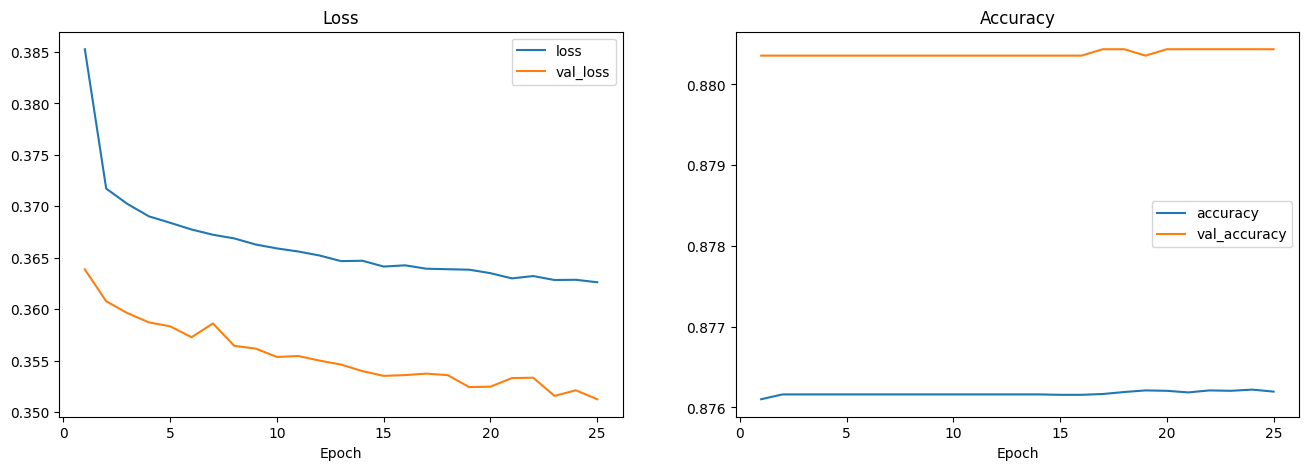

In [101]:
epoch=25
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),seq_hist_impove.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),seq_hist_impove.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),seq_hist_impove.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),seq_hist_impove.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

### Undersampling

In [102]:
model_seq = tf.keras.models.Sequential()
model_seq.add(tf.keras.layers.Dense(15, activation='relu',input_shape=(17,),kernel_initializer='GlorotNormal')) #input layer
model_seq.add(tf.keras.layers.BatchNormalization())
model_seq.add(tf.keras.layers.Dropout(0.1))
model_seq.add(tf.keras.layers.Dense(10, activation='relu')) #hidden layer
model_seq.add(tf.keras.layers.Dense(5, activation='relu')) #hidden layer
model_seq.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

model_seq.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

seq_hist_impove = model_seq.fit(train_under,y_under,batch_size=250, epochs=25, validation_data=(final_X_test,y_test))

Epoch 1/25
200/200 [==============================] - 1s 3ms/step - loss: 0.7151 - accuracy: 0.5050 - val_loss: 0.6765 - val_accuracy: 0.5756
Epoch 2/25
200/200 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5260 - val_loss: 0.6920 - val_accuracy: 0.5026
Epoch 3/25
200/200 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5335 - val_loss: 0.7009 - val_accuracy: 0.4587
Epoch 4/25
200/200 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.5408 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 5/25
200/200 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5412 - val_loss: 0.6974 - val_accuracy: 0.4845
Epoch 6/25
200/200 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5490 - val_loss: 0.6912 - val_accuracy: 0.5042
Epoch 7/25
200/200 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5477 - val_loss: 0.6934 - val_accuracy: 0.4914
Epoch 

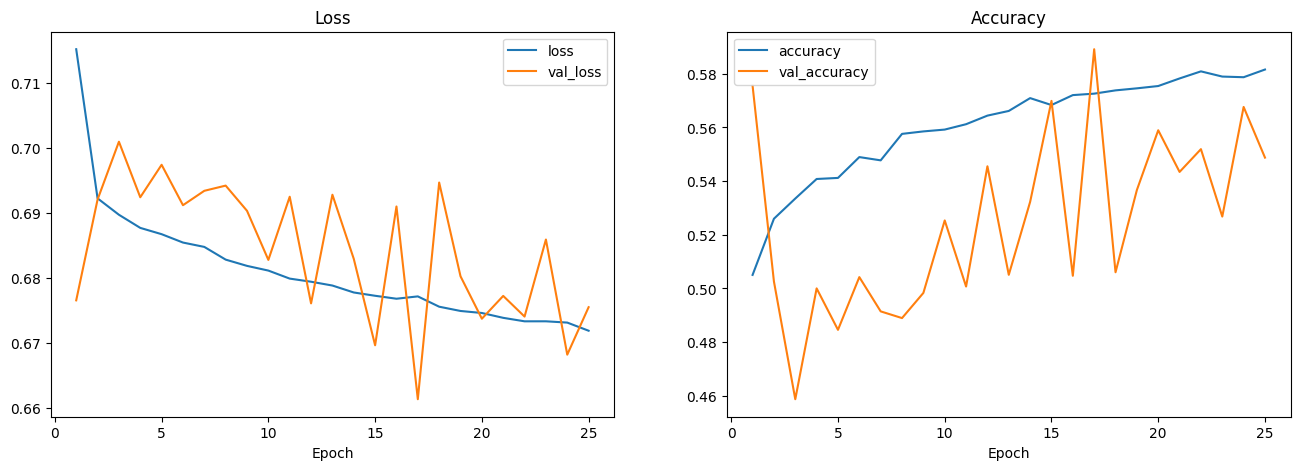

In [103]:
epoch=25
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),seq_hist_impove.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),seq_hist_impove.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),seq_hist_impove.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),seq_hist_impove.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

### Oversampling

In [104]:
model_seq = tf.keras.models.Sequential()
model_seq.add(tf.keras.layers.Dense(15, activation='relu',input_shape=(17,),kernel_initializer='GlorotNormal')) #input layer
model_seq.add(tf.keras.layers.BatchNormalization())
model_seq.add(tf.keras.layers.Dropout(0.1))
model_seq.add(tf.keras.layers.Dense(10, activation='relu')) #hidden layer
model_seq.add(tf.keras.layers.Dense(5, activation='relu')) #hidden layer
model_seq.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

model_seq.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

seq_hist_impove = model_seq.fit(X_smote,y_smote,batch_size=250, epochs=25, validation_data=(final_X_test,y_test))

Epoch 1/25
1414/1414 [==============================] - 3s 1ms/step - loss: 0.6850 - accuracy: 0.5484 - val_loss: 0.6640 - val_accuracy: 0.6271
Epoch 2/25
1414/1414 [==============================] - 2s 1ms/step - loss: 0.6758 - accuracy: 0.5745 - val_loss: 0.6496 - val_accuracy: 0.6722
Epoch 3/25
1414/1414 [==============================] - 2s 1ms/step - loss: 0.6715 - accuracy: 0.5814 - val_loss: 0.6378 - val_accuracy: 0.6840
Epoch 4/25
1414/1414 [==============================] - 2s 1ms/step - loss: 0.6681 - accuracy: 0.5885 - val_loss: 0.6714 - val_accuracy: 0.6212
Epoch 5/25
1414/1414 [==============================] - 2s 1ms/step - loss: 0.6664 - accuracy: 0.5909 - val_loss: 0.6328 - val_accuracy: 0.6966
Epoch 6/25
1414/1414 [==============================] - 2s 1ms/step - loss: 0.6644 - accuracy: 0.5933 - val_loss: 0.6449 - val_accuracy: 0.6658
Epoch 7/25
1414/1414 [==============================] - 2s 1ms/step - loss: 0.6632 - accuracy: 0.5969 - val_loss: 0.6510 - val_accuracy:

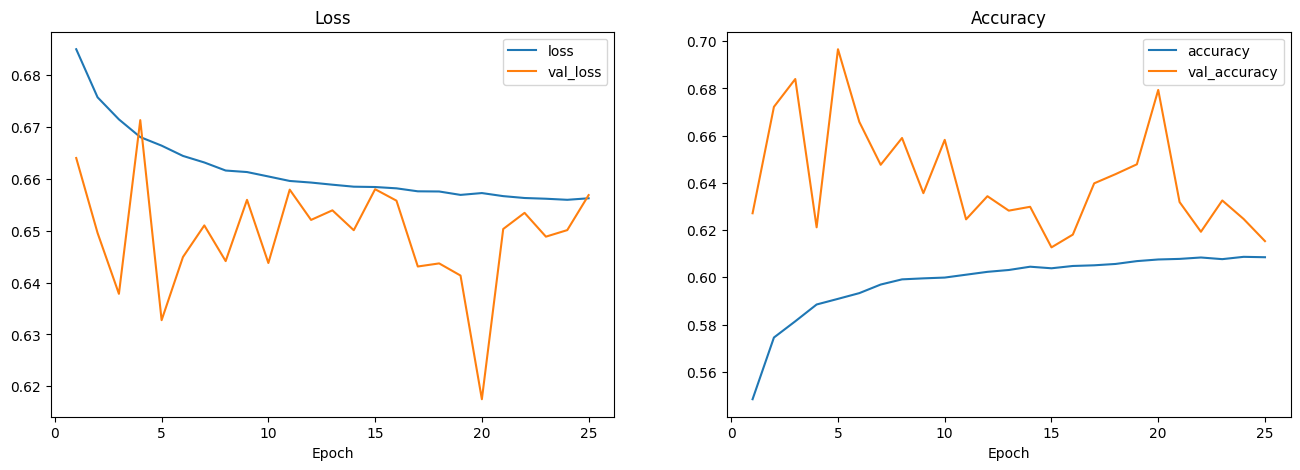

In [105]:
epoch=25
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),seq_hist_impove.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),seq_hist_impove.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),seq_hist_impove.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),seq_hist_impove.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

pada model ANN ( Deep Learning ), performa model undersampling dan oversampling tidak stabil ditandai banyaknya exploding gradient

## Random Forest Classifier

### Original

In [106]:
model = RandomForestClassifier(random_state=42)
model.fit(final_X_train,y_train)

RandomForestClassifier(random_state=42)

In [107]:
print('Training score: {:.4f}'.format(model.score(final_X_train, y_train)))
print('Test score: {:.4f}'.format(model.score(final_X_test, y_test)))

Training score: 0.9361
Test score: 0.9008


### Undersampling

In [108]:
rf_under = RandomForestClassifier(random_state=9)
rf_under.fit(train_under,y_under)

RandomForestClassifier(random_state=9)

In [109]:
print('Training score: {:.4f}'.format(rf_under.score(train_under,y_under)))
print('Test score: {:.4f}'.format(rf_under.score(final_X_test, y_test)))

Training score: 0.9574
Test score: 0.8706


### Oversampling

In [110]:
rf_over = RandomForestClassifier(random_state=9)
rf_over.fit(X_smote,y_smote)

RandomForestClassifier(random_state=9)

In [111]:
print('Training score: {:.4f}'.format(rf_over.score(X_smote,y_smote)))
print('Test score: {:.4f}'.format(rf_over.score(final_X_test, y_test)))

Training score: 0.9575
Test score: 0.8898


# Model Tuning

selanjutnya saya akan melakukan tuning terhadap model terbaik

In [112]:
# # # Definisikan grid hyperparameter yang akan diuji
# param_grid = {"n_estimators": [50,100,300],
#        "max_depth":[10,30,None],
#        "random_state":[9]     }

# # Buat objek GridSearchCV dengan model, grid parameter, dan metrik evaluasi
# grid_search = GridSearchCV(model, param_grid,cv=5)

#  # Latih GridSearchCV pada data latih
# grid_search.fit(final_X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 30, None],
                         'n_estimators': [50, 100, 300], 'random_state': [9]})

Code diatas saya ubah menjadi comment dikarenakan Prosesnya yang lama ( 20-80 menit tergantung device )

In [113]:
 # Cetak parameter terbaik yang ditemukan
print("Parameter terbaik:", grid_search.best_params_)

Parameter terbaik: {'max_depth': 30, 'n_estimators': 300, 'random_state': 9}


In [114]:
print('Training score: {:.4f}'.format(grid_search.score(final_X_train, y_train)))
print('Test score: {:.4f}'.format(grid_search.score(final_X_test, y_test)))

Training score: 0.9361
Test score: 0.9011


Dikarenakan hasil dari tuning tidak naik banyak saya akan menggunakan model base nya untuk disimpan. hal ini dikarenakan model yang telah melewati gridsearch ukurannya akan jauh lebih besar dibandingkan model base nya

# Model Evaluation

In [115]:
ori_pred = model.predict(final_X_test)
print(classification_report(y_test,ori_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     44370
           1       0.59      0.55      0.57      6030

    accuracy                           0.90     50400
   macro avg       0.77      0.75      0.76     50400
weighted avg       0.90      0.90      0.90     50400



In [116]:
under_pred = rf_under.predict(final_X_test)
print(classification_report(y_test,under_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     44370
           1       0.48      0.83      0.61      6030

    accuracy                           0.87     50400
   macro avg       0.73      0.85      0.76     50400
weighted avg       0.91      0.87      0.88     50400



In [117]:
over_pred = rf_over.predict(final_X_test)
print(classification_report(y_test,over_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94     44370
           1       0.53      0.79      0.63      6030

    accuracy                           0.89     50400
   macro avg       0.75      0.85      0.78     50400
weighted avg       0.92      0.89      0.90     50400



```
Pada sektor Bisnis Peminjaman uang, mengetahui seseorang akan menunggak( risk_flag = 1 ) adalah hal terpenting. Berdasarkan hal itu maka Metrics paling penting yang perlu dilihat pada classification report ialah Recall pada target 1. maka dapat disimpulkan disini bahwa model terbaik dari ketiga model diatas ialah yang Data nya dilakukan Undersampling dikarenakan Recall nya paling tinggi diantara yang lain. akan tetapi apabila precision juga penting( memprediksi risiko padahal sebenarnya aman ( False Positif ) ) Maka metrics terpenting ialah F1 Score. F1 score disini ialah rata-rata harmonik antara precision dan recall. jika melihat dari F1 score maka model dengan data yang dilakukan oversampling ialah yang terbaik . Dari ketiga model ini semuanya sudah termasuk goodfit dikarenakan performansi pada data train dan data tes nya tidak berbeda jauh dan performa model sudah ada diatas standar
```

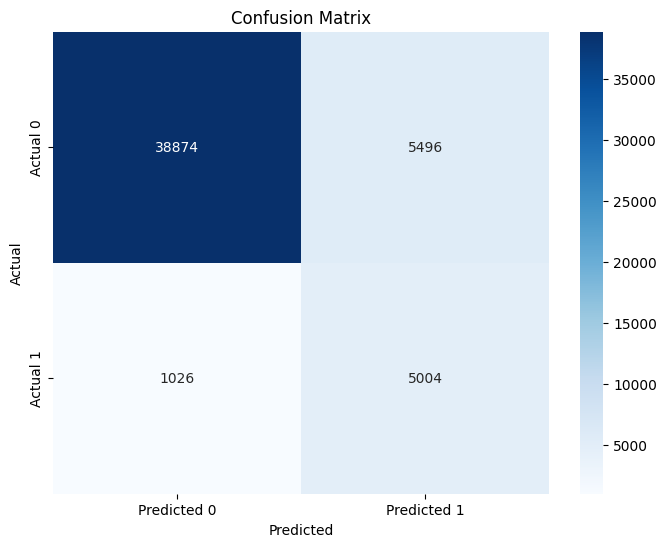

In [118]:
# Membuat confusion matrix
cm = confusion_matrix(y_test, under_pred)

# Membuat plot confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

disini saya membuat confusion matrix berdasarkan model yang menggunakan data undersampling, target utama saya ialah mengurangi false negatif ( orang yang harusnya menunggak tetapi model memprediksinya sebagai tidak menunggak ), yaitu pada data ini sebesar 1034

# Model Saving

In [119]:
# Simpan model menggunakan joblib
prep = "preprocessor.joblib"
dump(preprocessor, prep)

model_base = 'model_RF_base.joblib'
dump(model,model_base)
model_under = 'model_RF_under.joblib'
dump(rf_under,model_under)
model_over = 'model_RF_over.joblib'
dump(rf_over,model_over)

['model_RF_over.joblib']

# Summary

```
Berdasarkan EDA, Seorang individu yang memiliki gaji antara 0 hingga 1 juta, berusia antara 20 hingga 25 tahun, pengalaman kerja kurang dari 3 tahun, status lajang, tinggal dalam sewa rumah, tidak memiliki mobil, dan bekerja sebagai seorang polisi di kota Bhubaneswar, negara bagian Manipur, memiliki risiko menunggak yang paling tinggi. Untuk mengurangi risiko default dari individu dengan profil seperti yang telah disebutkan, perusahaan dapat menerapkan beberapa strategi :

• Penyuluhan Keuangan: Berikan sumber daya dan pelatihan keuangan kepada peminjam yang memiliki profil risiko tinggi. Ini dapat membantu mereka mengelola keuangan mereka dengan lebih efektif, meningkatkan kemungkinan mereka untuk membayar kembali pinjaman. Bekerja sama dengan lembaga pendidikan, pelatihan, atau penyalur tenaga kerja setempat untuk memberikan pelatihan tambahan kepada peminjam dengan profil risiko tinggi. Ini dapat membantu meningkatkan peluang mereka untuk mendapatkan pendapatan yang lebih baik di masa depan.

• Pilihan Jaminan atau Penjamin: Pertimbangkan untuk meminta jaminan atau penjamin dalam bentuk aset yang dapat diakui nilainya sebagai bagian dari persyaratan pinjaman. Ini dapat memberikan perlindungan tambahan terhadap risiko default.
```

```
further improvement for model, mungkin dapat dilakukan hyperparameter tuning ulang. dikarenakan model yang sekarang digunakan ialah model baseline sehingga masih terbuka kemungkinan model performa masih bisa meningkat. untuk aspek yang lain mungkin dapat mencoba filtering kembali fitur yang akan digunakan untuk pemodelan
```